# DQN with `dm_control`

Here are some experiments using deep Q-Learning to solve simple continuous control tasks. I implemented [the original DQN](https://www.nature.com/articles/nature14236) and used it to solve several tasks in the [DeepMind Control Suite](https://arxiv.org/abs/1801.00690). The main ideas are:
1. Maintain a replay buffer of experiences that are drawn from for training. This decreases correlations in the training data.
2. Keep an additional Q network used for calculating targets that is updated less frequently that the main Q network. This stabalizes the updates.

Q-Learning takes the max across actions, which is not ideal for continuous action spaces. In this implementation the action space is discretized, such that each action dimension can take a value in `linspace(action_min, actions_max, action_grid)`, where `action_grid` $\in (2,3)$ in this demo. The full action space is the cartesian product of the vectors for each dimension.

The demo is organized as follows:
1. **setup**
2. **solving tasks:** pendulum, cartpole, ball in cup
3. **double DQN:** I implement [Double Q-Learning](https://arxiv.org/abs/1509.06461) and show that it increases the accuracy of action-value estimates.
4. **encouraging exploration:** To increase exploration I used a simple trick to encourage optimism in the face of uncertainty. Namely, I pretrained the network to output optimistic action-values across the state-space, which encourages exploration in the early phases of learning.  

# setup

We start by defining some utility functions that will help with plotting and training. To increase training speed I found it helpful to:
- *Train on the CPU rather than GPU.* The Q network is very small. My CPU was faster than the GPU unless batch sizes were really large.
- *Perform forward passes on Numpy*. Network forward passes ended up being much faster using numpy rather than Tensorflow (again, unless batch sizes were really large).
- *Train multiple agents in parallel*. Training results could be somewhat idiosyncratic even with the same hyperparameters, so I train 12 agents in parallel to make sure the results are robust.

In [43]:
#@title setup

%load_ext autoreload
%autoreload 2

from concurrent.futures import ProcessPoolExecutor
from dm_control_tests.agents import Agent
from dm_control_tests import train_utils, plot_utils
import matplotlib.pyplot as plt
from dm_control import suite
from itertools import repeat
import numpy as np
train_utils.disable_gpu()


# plot performance over training, averaged across agents
def plot_performance(x, data):
    ax = plt.axes(xlabel='episode', ylabel='return',
                  xlim=(x[0],x[-1]), ylim=(0,1000))
    data = np.array(data)
    mean = data.mean(0)
    std = data.std(0)
    ax.plot(x, data.T, color=(0,0,0), alpha=.15)
    ax.plot(x, mean)
    ax.fill_between(x, mean+std, mean-std, alpha=.15)

# train multiple agents in parallel on a particular domain and task
def train_agents_parallel(domain_and_task, agent_args, train_args,
                         optimistic_q=None, n_agents=12, n_workers=12, save_path=None):
    
    if save_path is not None:
        paths = ['{}_{:3d}'.format(save_path, i) for i in range(n_agents)]
    else:
        repeat(None, n_agents)
    
    with ProcessPoolExecutor(max_workers=n_workers) as executor:    
        results = executor.map(train_utils.create_and_train_agent, 
                               repeat(domain_and_task, n_agents),
                               repeat(agent_args),
                               repeat(train_args),
                               repeat(optimistic_q),
                               paths,
                               [True]+list(repeat(False, n_agents-1)))  # only verbose for first thread
        results = [r for r in results]
    episode_num = results[0][0]
    avg_returns = np.array([np.array(r[1]).mean(1) for r in results])
    weights = [r[2] for r in results]
    return episode_num, avg_returns, weights

# show a rollout for the agent with the best performance at the end of training
def show_best_agent_rollout(domain_and_task, avg_returns, weights, agent_args, framerate=30):
    env = suite.load(*domain_and_task)
    agent = Agent(env.observation_spec(), env.action_spec(), **agent_args)
    best_agent = np.argmax(avg_returns[:,-1])  # hightest return at end of training
    agent.q.set_weights(weights[best_agent])
    return plot_utils.show_rollout_jupyter(agent, env, epsilon=.05, framerate=framerate)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### training
Let's set up the hyperparameters for training. Every action dimension will be discretized into `action_grid=2` actions. This makes training fast, but it also means a given action can't be set to `0`. We will use a replay buffer of size `buffer_length=50000` that is initialized using random actions prior to training and a Q network with hidden layers of size `units_per_layer=(12,24)`.  The target Q network will be updated after every `q_update_interval=100` updates of the main Q network.

The temporal resolution of the `dm_control` environments is rather high. During exploration, especially with sparse rewards, the sequence of correctly chosen actions necessary to discover the reward may be quite long. Therefore (as in the original paper), I repeat each action `action_repeats=2` times. Furthermore, I only perform network updates every `steps_per_update=4` iterations. The updates, rather than the physics simulations, are the speed bottleneck. This allows the agent to see more episodes with the same number of updates.

I train for `episodes=200` episodes with `batch_size=64`, acting $\epsilon$-greedy with $\epsilon$ linearly annealed from `epsilon_start=1` to `epsilon_final=.1` over `epsilon_final_episode=100` episodes.

### evaluation
Finally, every `eval_interval = 10` episodes I estimate the return by averaging the return from 5 rollouts with $\epsilon = .05$. $12$ agents are trained in parallel, and I plot the average += standard deviation of the return across these agents.

In [18]:
# @title hyperparameters 

# agent
agent_args = dict(
    action_grid = 2,            # number of discrete actions per action dimension
    units_per_layer = (12,24),  # hidden units per layer
    buffer_length = 50000,
    q_update_interval = 100,    # q updates per q_target update
    learning_rate = .001,       # learning rate (adam optimizer)       
)

# training
train_args = dict(
    episodes = 200,
    eval_interval = 10,
    batch_size = 64,
    action_repeats = 2,         # repeat each action this number of times during training
    steps_per_update = 4,       # environment steps before updating q
    gamma = .99,
    epsilon_start = 1,
    epsilon_final = .1,
    epsilon_final_episode = 100,   # episode at which epsilon_final is reached
)

# solving simple tasks
will solve pendulum, swing up, and ball in cup

## cartpole (balance)

- state space only r2 and action space r1 - try this out to make sure everything is in order
- explain evaluation metrics... evaluated every n eps, avg of m eps with z epsilon

training agent...


iteration   10, avg return 323.8
iteration   20, avg return 369.8
iteration   30, avg return 283.8
iteration   40, avg return 351.6
iteration   50, avg return 627.5
iteration   60, avg return 739.0
iteration   70, avg return 499.7
iteration   80, avg return 798.2
iteration   90, avg return 620.8
iteration  100, avg return 629.4
iteration  110, avg return 615.7
iteration  120, avg return 682.6
iteration  130, avg return 798.3
iteration  140, avg return 799.3
iteration  150, avg return 700.4
iteration  160, avg return 764.2
iteration  170, avg return 798.6
iteration  180, avg return 797.8
iteration  190, avg return 626.0
iteration  200, avg return 779.1



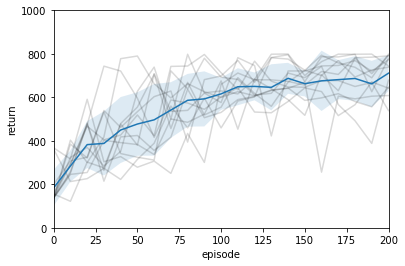

In [3]:
episode_num, avg_returns, weights = train_agents_parallel(
    ('cartpole', 'balance'), agent_args, train_args, n_agents=12, n_workers=12)
plot_performance(episode_num, avg_returns)

In [8]:
show_best_agent_rollout(('cartpole', 'balance'), avg_returns, weights, agent_args)

## cartpole (swingup)

training agent...


iteration   10, avg return 121.8
iteration   20, avg return 181.0
iteration   30, avg return 243.6
iteration   40, avg return 259.6
iteration   50, avg return 141.2
iteration   60, avg return 239.3
iteration   70, avg return 448.9
iteration   80, avg return 335.0
iteration   90, avg return 412.1
iteration  100, avg return 515.5
iteration  110, avg return 464.1
iteration  120, avg return 663.6
iteration  130, avg return 513.2
iteration  140, avg return 530.1
iteration  150, avg return 535.4
iteration  160, avg return 565.0
iteration  170, avg return 538.2
iteration  180, avg return 251.9
iteration  190, avg return 472.4
iteration  200, avg return 425.7



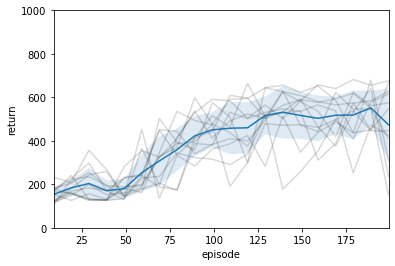

In [4]:
episode_num, avg_returns, weights = train_agents_parallel(
    ('cartpole', 'swingup'), agent_args, train_args, n_agents=12, n_workers=12)
plot_performance(episode_num, avg_returns)

In [5]:
show_best_agent_rollout(('cartpole', 'swingup'), avg_returns, weights, agent_args)

## ball in cup

training agent...


iteration   10, avg return 169.0
iteration   20, avg return 190.8
iteration   30, avg return 89.0
iteration   40, avg return  0.0
iteration   50, avg return 189.8
iteration   60, avg return  0.0
iteration   70, avg return 267.8
iteration   80, avg return 497.0
iteration   90, avg return 199.4
iteration  100, avg return 513.2
iteration  110, avg return 489.0
iteration  120, avg return 282.6
iteration  130, avg return 819.4
iteration  140, avg return 580.0
iteration  150, avg return 358.2
iteration  160, avg return 325.6
iteration  170, avg return 204.6
iteration  180, avg return 688.0
iteration  190, avg return 340.6
iteration  200, avg return 676.8



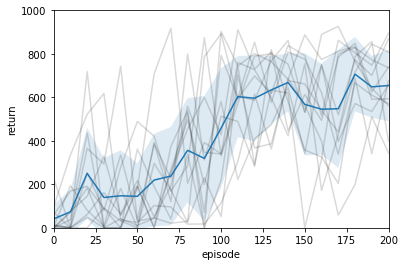

In [3]:
episode_num, avg_returns, weights = train_agents_parallel(
    ('ball_in_cup', 'catch'), agent_args, train_args, n_agents=12, n_workers=12)
plot_performance(episode_num, avg_returns)

In [19]:
show_best_agent_rollout(('ball_in_cup', 'catch'), avg_returns, weights, agent_args)

# double q learning
max operation leads to overly optimistic q values // double q have two q functions learned on dft data samples // dqn doesn't go this far, but uses it's two q functions for action selection and evaluation... increases accuracy of q estimates, as shown in pendulum...

training agent...


iteration   10, avg return 83.4
iteration   20, avg return 332.4
iteration   30, avg return 101.8
iteration   40, avg return 191.6
iteration   50, avg return 41.6
iteration   60, avg return 66.4
iteration   70, avg return 501.4
iteration   80, avg return 142.0
iteration   90, avg return 156.2
iteration  100, avg return 574.2
iteration  110, avg return 501.0
iteration  120, avg return 675.4
iteration  130, avg return 893.0
iteration  140, avg return 545.0
iteration  150, avg return 638.2
iteration  160, avg return 639.8
iteration  170, avg return 210.6
iteration  180, avg return 419.8
iteration  190, avg return 135.0
iteration  200, avg return 333.0



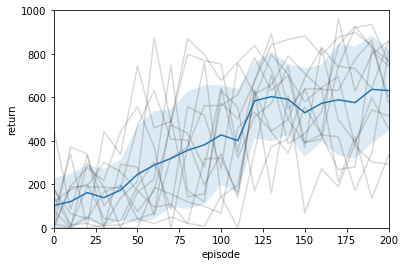

In [3]:
agent_args_mod = agent_args
agent_args_mod['double_dqn'] = True

episode_num, avg_returns, weights = train_agents_parallel(
    ('ball_in_cup', 'catch'), agent_args_mod, train_args, n_agents=12, n_workers=12)
plot_performance(episode_num, avg_returns)

In [5]:
show_best_agent_rollout(('ball_in_cup', 'catch'), avg_returns, weights, agent_args)

# optimistic initializations
for sparse reward agent needs to accidentally discover correct action sequence // can be very hard when that sequence is long // initializing optimisitic values of q can hopefully encourage initial exploration and speed up learning...

initializing q with optimistic values...
pre training avg value: -0.02
pre training avg value: -0.02
pre training avg value: -0.01
pre training avg value: 0.19
pre training avg value: -0.02
pre training avg value: 0.13
pre training avg value: 0.18
pre training avg value: 0.04


pre training avg value: -0.07
pre training avg value: -0.04
pre training avg value: 0.13
pre training avg value: -0.20
post training avg value: 86.14
post training avg value: 86.17
post training avg value: 86.94
post training avg value: 85.45
post training avg value: 86.29
post training avg value: 85.66
post training avg value: 86.17
post training avg value: 86.40
post training avg value: 86.13
post training avg value: 86.29
post training avg value: 86.16

post training avg value: 87.65
training agent...


iteration   10, avg return 73.3
iteration   20, avg return 71.1
iteration   30, avg return 69.4
iteration   40, avg return 83.7
iteration   50, avg return 22.8
iteration   60, avg return 98.0
iteration   70, avg return 178.6
iteration   80, avg return 204.1
iteration   90, avg return 386.8
iteration  100, avg return 286.9
iteration  110, avg return 170.3
iteration  120, avg return 131.8
iteration  130, avg return 137.4
iteration  140, avg return 230.2
iteration  150, avg return 299.0
iteration  160, avg return 476.6
iteration  170, avg return 572.1
iteration  180, avg return 517.1
iteration  190, avg return 492.0
iteration  200, avg return 501.6



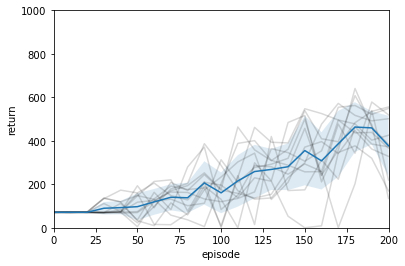

In [3]:
episode_num, avg_returns, weights = train_agents_parallel(('cartpole', 'swingup'),
    agent_args, train_args, n_agents=12, n_workers=12, optimistic_q=100)
plot_performance(episode_num, avg_returns)

# sandbox...

In [49]:
# train single model, saving to disk...
test_path = 'dm_control_tests/models/test_model'
train_args_temp = train_args
train_args_temp['episodes'] = 2
train_utils.create_and_train_agent(('cartpole', 'swingup'), agent_args, train_args, save_path=test_path);


training agent...



INFO:tensorflow:Assets written to: dm_control_tests/models/test_model/q_network/assets


INFO:tensorflow:Assets written to: dm_control_tests/models/test_model/q_network/assets


In [51]:
# load saved model
agent, metadata = train_utils.load_agent(test_path)
agent.q.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_108 (Dense)            (None, 12)                72        
_________________________________________________________________
dense_109 (Dense)            (None, 24)                312       
_________________________________________________________________
dense_110 (Dense)            (None, 2)                 50        
Total params: 434
Trainable params: 434
Non-trainable params: 0
_________________________________________________________________
